In [3]:
'''Libraries'''
import numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Subset
from laplace import Laplace
import matplotlib.pyplot as plt
import laplace
import pickle
import os
import random
import time
from scipy.stats import pearsonr, spearmanr

In [3]:
'''Dataset Loader for Digits dataset'''
np.random.seed(0)
torch.manual_seed(0)

# Data
digits = load_digits()
X, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

Xtr_t = torch.from_numpy(Xtr)
ytr_t = torch.from_numpy(ytr)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

train_set = TensorDataset(Xtr_t, ytr_t)
print(train_set)
n_train = len(train_set)

Task 1

In [ ]:
def cumulative_explained_ratio(val, alpha=0.9):
    """
    val: list or np.array of eigenvalues (can be positive/negative)
    alpha: target cumulative proportion (e.g., 0.9)
    
    Returns:
        ratio (float): index/p where cumulative sum first exceeds alpha
        idx (int): the actual index achieving it
    """
    val = np.array(val, dtype=float)
    # 음수 값은 curvature 설명에 기여하지 않도록 제거 (필요시 옵션화 가능)
    val = np.maximum(val, 0)
    
    if np.sum(val) == 0:
        return 0.0, 0

    sorted_vals = np.sort(val)[::-1]  # 내림차순 정렬
    cumvals = np.cumsum(sorted_vals)
    total = cumvals[-1]
    threshold = alpha * total

    idx = np.searchsorted(cumvals, threshold)
    ratio = (idx + 1) / len(val)
    return ratio, idx + 1

In [ ]:
n_repeats = 10
alpha = 0.9
results = {}

for repeat in range(n_repeats):
    print(f"\n=== Repetition {repeat+1}/{n_repeats} ===")
    
    # 💡 매 반복마다 fresh initialization
    models = get_models()

    for model in models:
        n_params = count_parameters(model)
        x_val = np.log(n_params)

        print(f"\nTraining model with {n_params} parameters (repeat {repeat+1})")

        torch.manual_seed(repeat)
        np.random.seed(repeat)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=256, shuffle=False)
        train_eval_loader = DataLoader(train_set, batch_size=256, shuffle=False)

        n_epochs_monitor = 30
        for epoch in range(n_epochs_monitor):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        # after training:
        la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
        la.fit(train_loader)
        val = la.H.cpu().numpy()

        ratio, idx = cumulative_explained_ratio(val, alpha=alpha)

        # 💾 ratio + full eigenvalues 둘 다 저장
        results.setdefault(x_val, []).append({
            'ratio': ratio,
            'eigenvalues': val
        })

with open("results_curvature_concentration.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
def _safe_extract_eigvals(obj):
    """
    Try to find an eigenvalue array (np.ndarray or list-like) inside obj.
    Return a 1D numpy array if found, else return None.
    Handles: np.ndarray, list/tuple of arrays, dict with keys like 'eigenvalues','eigvals','H','values',
    and nested structures.
    """
    # direct numpy array
    if isinstance(obj, np.ndarray):
        return obj.flatten()

    # numpy scalar or Python scalar -> not an eigenvalue array
    if isinstance(obj, (np.floating, np.integer, float, int, np.float64, np.int64)):
        return None

    # list/tuple -> try each element
    if isinstance(obj, (list, tuple)):
        for item in obj:
            arr = _safe_extract_eigvals(item)
            if arr is not None:
                return arr
        return None

    # dict -> try common keys first, then recurse over values
    if isinstance(obj, dict):
        # common possible keys that hold eigenvalues
        preferred_keys = ['eigenvalues', 'eigvals', 'eigvals_', 'H', 'values', 'vals', 'eigs', 'eigen']
        for k in preferred_keys:
            if k in obj:
                arr = _safe_extract_eigvals(obj[k])
                if arr is not None:
                    return arr

        # if none of preferred keys, recurse values (but skip scalar values)
        for v in obj.values():
            arr = _safe_extract_eigvals(v)
            if arr is not None:
                return arr
        return None

    # other types (pandas, torch tensor) - handle torch tensors
    try:
        import torch
        if isinstance(obj, torch.Tensor):
            return obj.detach().cpu().numpy().flatten()
    except Exception:
        pass

    # fallback: not recognized
    return None

def plot_cumulative_explained_ratio(results, alpha=0.9, save_path=None):
    """
    results: dict { log(n_params): [ either floats OR dicts with 'ratio' key ] }
    Draws median +/- std errorbar and saves figure.
    """
    xs = []
    medians = []
    stds = []
    for x_val, items in results.items():
        ratios = []
        # items may be list of floats or list of dicts or mixed
        for it in items:
            if isinstance(it, dict) and 'ratio' in it:
                try:
                    ratios.append(float(it['ratio']))
                except Exception:
                    pass
            elif isinstance(it, (float, int, np.floating, np.integer)):
                ratios.append(float(it))
            else:
                # maybe nested dict with ratio inside
                if isinstance(it, dict):
                    for v in it.values():
                        if isinstance(v, (float, int, np.floating, np.integer)):
                            ratios.append(float(v))
                            break
        if len(ratios) == 0:
            # skip if nothing found
            print(f"⚠️  No ratio entries found for x={x_val}, skipping.")
            continue
        xs.append(float(x_val))
        medians.append(np.median(ratios))
        stds.append(np.std(ratios))

    if len(xs) == 0:
        print("⚠️ No ratio data found in results. Nothing to plot.")
        return

    xs = np.array(xs)
    order = np.argsort(xs)
    xs = xs[order]
    medians = np.array(medians)[order]
    stds = np.array(stds)[order]

    plt.figure(figsize=(8,6))
    plt.errorbar(xs, medians, yerr=stds, fmt='o-', capsize=5, ecolor='gray', elinewidth=1.5)
    plt.xlabel("log(Number of parameters)")
    plt.ylabel(f"Cumulative explained ratio (α={alpha})")
    plt.title("Model Complexity vs. Curvature Concentration")
    plt.grid(True, alpha=0.3)

    os.makedirs("figs", exist_ok=True)
    if save_path is None:
        save_path = f"figs/cumulative_explained_ratio_{time.strftime('%Y%m%d_%H%M%S')}.png"
    else:
        # ensure directory exists
        d = os.path.dirname(save_path)
        if d:
            os.makedirs(d, exist_ok=True)

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved cumulative ratio plot → {save_path}")

def plot_logdet_vs_tracebound(results, save_path=None, clip_eps=1e-8):
    """
    results: dict { log(n_params): [ items ] }
    Each item can be:
      - a dict containing 'eigenvalues' (or 'eigvals', 'H', etc.)
      - a direct np.ndarray of eigenvalues
      - nested lists/dicts
    This computes per-trial:
      logdet = sum(log(clipped_eigvals))
      trace_bound = d * log(mean(clipped_eigvals))
    Then plots median +/- std across trials for each x (log n_params).
    """
    xs = []
    logdet_medians = []
    logdet_stds = []
    trace_medians = []
    trace_stds = []

    for x_val, items in results.items():
        # collect all eig arrays found under this x_val
        eig_lists = []
        for it in items:
            arr = _safe_extract_eigvals(it)
            if arr is None:
                continue
            # convert to numpy and flatten
            try:
                arr = np.array(arr, dtype=float).flatten()
            except Exception:
                continue
            eig_lists.append(arr)

        if len(eig_lists) == 0:
            print(f"⚠️ No eigenvalue arrays found for x={x_val}, skipping.")
            continue

        logdets = []
        tracebounds = []
        for eig in eig_lists:
            # sanitize values
            eig = eig[np.isfinite(eig)]
            if eig.size == 0:
                continue
            eig = np.clip(eig, clip_eps, None)  # avoid non-positive
            d = eig.size
            if d == 0:
                continue
            logdet = np.sum(np.log(eig))
            tracebound = d * np.log(np.sum(eig) / d)
            logdets.append(logdet)
            tracebounds.append(tracebound)

        if len(logdets) == 0:
            print(f"⚠️ After sanitization no valid eigvals for x={x_val}, skipping.")
            continue

        xs.append(float(x_val))
        logdet_medians.append(np.median(logdets))
        logdet_stds.append(np.std(logdets))
        trace_medians.append(np.median(tracebounds))
        trace_stds.append(np.std(tracebounds))

    if len(xs) == 0:
        print("⚠️ No valid data to plot for logdet vs tracebound.")
        return

    xs = np.array(xs)
    order = np.argsort(xs)
    xs = xs[order]
    logdet_medians = np.array(logdet_medians)[order]
    logdet_stds = np.array(logdet_stds)[order]
    trace_medians = np.array(trace_medians)[order]
    trace_stds = np.array(trace_stds)[order]

    plt.figure(figsize=(8,6))
    plt.errorbar(xs, logdet_medians, yerr=logdet_stds, fmt='o-', label='log|H| (∑ log λ_i)')
    plt.errorbar(xs, trace_medians, yerr=trace_stds, fmt='s--', label='trace bound (d·log(tr/d))')
    plt.xlabel("log(Number of parameters)")
    plt.ylabel("Value")
    plt.title("Log-determinant vs. Trace Bound (Curvature Scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    os.makedirs("figs", exist_ok=True)
    if save_path is None:
        save_path = f"figs/logdet_vs_tracebound_{time.strftime('%Y%m%d_%H%M%S')}.png"
    else:
        d = os.path.dirname(save_path)
        if d:
            os.makedirs(d, exist_ok=True)

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved logdet/trace plot → {save_path}")

with open("results_curvature_concentration.pkl", "rb") as f:
    results = pickle.load(f)
plot_logdet_vs_tracebound(results, save_path='logdet_vs_tracebound.png')
plot_cumulative_explained_ratio(results, alpha=0.9, save_path='cumulative_explained_ratio.png')

✅ Saved logdet/trace plot → logdet_vs_tracebound.png
✅ Saved cumulative ratio plot → cumulative_explained_ratio.png


Task 2

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

# Data 준비 (기존 Xtr_t, ytr_t 사용)
digits = load_digits()
x, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
Xtr, Xte, ytr, yte = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

Xtr_t = torch.from_numpy(Xtr)          # (N_train, D)
ytr_t = torch.from_numpy(ytr).long()   # (N_train,)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

num_pretrain = 30
indices = list(range(len(Xtr_t)))
random.shuffle(indices)
labeled_indices = indices[:num_pretrain]       # 실제 dataset 인덱스들
unlabeled_indices = indices[num_pretrain:]

# 기본 전체 텐서데이터셋 하나 생성
full_train_dataset = TensorDataset(Xtr_t, ytr_t)

# Subset으로 라벨/언라벨드 관리 (TensorDataset에 직접 numpy 넣지 않음)
train_set_Labeled = Subset(full_train_dataset, labeled_indices)
train_set_Unlabeled = Subset(full_train_dataset, unlabeled_indices)
test_set = TensorDataset(Xte_t, yte_t)


def save_datasets(train_set_Labeled, train_set_Unlabeled, test_set, save_path='checkpoints/datasets.pkl'):
    """
    현재 train_set_Labeled, train_set_Unlabeled, test_set을 저장
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    data = {
        'labeled_indices': train_set_Labeled.indices,
        'unlabeled_indices': train_set_Unlabeled.indices,
        'full_dataset': train_set_Labeled.dataset,  # 전체 dataset (동일함)
        'test_set': test_set
    }
    
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"✅ Saved datasets to {save_path}")
    print(f"   - Labeled: {len(train_set_Labeled)} samples")
    print(f"   - Unlabeled: {len(train_set_Unlabeled)} samples")
    print(f"   - Test: {len(test_set)} samples")


def load_datasets(load_path='checkpoints/datasets.pkl'):
    """
    저장된 dataset들을 불러오기
    
    Returns:
        train_set_Labeled, train_set_Unlabeled, test_set
    """
    with open(load_path, 'rb') as f:
        data = pickle.load(f)
    
    full_dataset = data['full_dataset']
    train_set_Labeled = Subset(full_dataset, data['labeled_indices'])
    train_set_Unlabeled = Subset(full_dataset, data['unlabeled_indices'])
    test_set = data['test_set']
    
    print(f"✅ Loaded datasets from {load_path}")
    print(f"   - Labeled: {len(train_set_Labeled)} samples")
    print(f"   - Unlabeled: {len(train_set_Unlabeled)} samples")
    print(f"   - Test: {len(test_set)} samples")
    
    return train_set_Labeled, train_set_Unlabeled, test_set


# 저장
save_datasets(train_set_Labeled, train_set_Unlabeled, test_set, 
              save_path='checkpoints/initial_datasets.pkl')

✅ Saved datasets to checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples
✅ Loaded datasets from checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples


In [ ]:
def initialize_model_weights(model, init_type='xavier'):
    """
    모델 가중치를 초기화합니다.
    init_type: 'xavier', 'kaiming', 'normal', 'uniform'
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if init_type == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif init_type == 'kaiming':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif init_type == 'normal':
                nn.init.normal_(m.weight, mean=0, std=0.01)
            elif init_type == 'uniform':
                nn.init.uniform_(m.weight, -0.1, 0.1)
            
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    
    return model

def get_models():
    models = []

    # 1. 가장 단순한 모델
    models.append(nn.Linear(64, 10))

    # 2. 파라미터 2배: Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 3. 더 깊게: Linear + Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 4. 더 깊고 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 5. BatchNorm 추가
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ))

    # 6. Dropout 추가
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 7. 더 깊게, 더 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 8. 더 많은 레이어와 BatchNorm, Dropout
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 9. 더 깊고 넓게, 활성화 다양화
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 10. 가장 큰 모델
    models.append(nn.Sequential(
        nn.Linear(64, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    return models

def train_model(model, train_set_Labeled, criterion, optimizer, n_epochs=5):
    n_epochs_monitor = n_epochs
    for epoch in range(n_epochs_monitor):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_set_Labeled:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return model

def evaluate(loader, model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total

def count_parameters(model, only_trainable=False):
    """
    모델의 파라미터 개수를 반환합니다.
    only_trainable=True이면 requires_grad=True인 파라미터만 셉니다.
    """
    params = (p for p in model.parameters() if (not only_trainable) or p.requires_grad)
    return sum(p.numel() for p in params)

def save_model(model, save_path='checkpoints/model.pth'):
    """
    모델의 state_dict를 저장
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"✅ Saved model to {save_path}")

def load_model(model, load_path='checkpoints/model.pth'):
    """
    저장된 state_dict를 모델에 로드
    
    Args:
        model: 빈 모델 (구조만 정의된 상태)
        load_path: 저장된 모델 경로
    
    Returns:
        model: 가중치가 로드된 모델
    """
    model.load_state_dict(torch.load(load_path))
    print(f"✅ Loaded model from {load_path}")
    return model

def save_datasets(train_set_Labeled, train_set_Unlabeled, test_set, save_path='checkpoints/datasets.pkl'):
    """
    현재 train_set_Labeled, train_set_Unlabeled, test_set을 저장
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    data = {
        'labeled_indices': train_set_Labeled.indices,
        'unlabeled_indices': train_set_Unlabeled.indices,
        'full_dataset': train_set_Labeled.dataset,  # 전체 dataset (동일함)
        'test_set': test_set
    }
    
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"✅ Saved datasets to {save_path}")
    print(f"   - Labeled: {len(train_set_Labeled)} samples")
    print(f"   - Unlabeled: {len(train_set_Unlabeled)} samples")
    print(f"   - Test: {len(test_set)} samples")

def load_datasets(load_path='checkpoints/datasets.pkl'):
    """
    저장된 dataset들을 불러오기
    
    Returns:
        train_set_Labeled, train_set_Unlabeled, test_set
    """
    with open(load_path, 'rb') as f:
        data = pickle.load(f)
    
    full_dataset = data['full_dataset']
    train_set_Labeled = Subset(full_dataset, data['labeled_indices'])
    train_set_Unlabeled = Subset(full_dataset, data['unlabeled_indices'])
    test_set = data['test_set']
    
    print(f"✅ Loaded datasets from {load_path}")
    print(f"   - Labeled: {len(train_set_Labeled)} samples")
    print(f"   - Unlabeled: {len(train_set_Unlabeled)} samples")
    print(f"   - Test: {len(test_set)} samples")
    
    return train_set_Labeled, train_set_Unlabeled, test_set


def return_hessian_eigenvalues(model, train_set_Labeled):
    la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
    train_loader = DataLoader(train_set_Labeled, batch_size=32, shuffle=True)
    la.fit(train_loader)
    val = la.H
    return val


def fast_jacobian(model, x):
    model.zero_grad()
    # ensure batch dimension
    if x.ndim == 1:
        x = x.unsqueeze(0)  # (1, input_dim)
    b = x.shape[0]

    params = [p for p in model.parameters() if p.requires_grad]
    # precompute param sizes to flatten consistently
    param_numels = [p.numel() for p in params]

    J_batch = []
    for i in range(b):
        xi = x[i : i + 1]  # keep batch dim for forward
        yi = model(xi)  # (1, d_out)
        d_out = yi.shape[-1]

        # compute grads for this sample: result (d_out, n_params)
        J_i_rows = []
        for k in range(d_out):
            grads = torch.autograd.grad(yi[0, k], params, retain_graph=True)
            grad_flat = torch.cat([g.reshape(-1) for g in grads])
            J_i_rows.append(grad_flat)
        J_i = torch.stack(J_i_rows, dim=0)  # (d_out, n_params)
        J_batch.append(J_i)

    J_batch = torch.stack(J_batch, dim=0)  # (b, d_out, n_params)
    return J_batch

def compute_outcome_hessian_from_model(model, inputs):
    # inputs: (d,) or (b, d)
    if inputs.ndim == 1:
        inputs = inputs.unsqueeze(0)
    z = model(inputs)  # (b, d_out)
    p = torch.softmax(z, dim=-1)  # (b, d_out)
    # diag_embed builds (b, d_out, d_out)
    H = torch.diag_embed(p) - p.unsqueeze(2) * p.unsqueeze(1)  # (b, d_out, d_out)
    return H

def symmetric_matrix_sqrt(A, eps=1e-12):
    """
    A: (n,n) or (batch, n, n)
    returns: A_sqrt with same shape
    """
    single = (A.dim() == 2)
    if single:
        A = A.unsqueeze(0)
    w, v = torch.linalg.eigh(A)
    w_clamped = torch.clamp(w, min=eps)
    w_sqrt = torch.sqrt(w_clamped)
    A_sqrt = (v * w_sqrt.unsqueeze(-2)) @ v.transpose(-2, -1)
    if single:
        return A_sqrt[0]
    return A_sqrt

def low_rank_updated_part(model, x, return_batch: bool = False):
    """
    Returns:
      - if return_batch=True: U_batch of shape (b, n_params, d_out)
      - else: U_all of shape (n_params, b * d_out)  (backward-compatible)
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    H = compute_outcome_hessian_from_model(model, x)    # (b, d_out, d_out)
    J_batch = fast_jacobian(model, x)                   # (b, d_out, n_params)
    H_sqrt = symmetric_matrix_sqrt(H)                   # (b, d_out, d_out)

    # J_batch: (b, d_out, n_params) -> transpose -> (b, n_params, d_out)
    Jt = J_batch.transpose(1, 2)
    U_batch = torch.matmul(Jt, H_sqrt)                  # (b, n_params, d_out)

    if return_batch:
        return U_batch
    b, n_params, d_out = U_batch.shape
    U_all = U_batch.permute(1, 0, 2).reshape(n_params, b * d_out)
    return U_all

def DoptScore_per_sample(model, x, Hessian, eps=1e-10):
    """
    Compute D-opt score per input sample.
    - x: (input_dim,) or (b, input_dim)
    - Hessian: torch tensor (n_params,) (diagonal)
    Returns: torch tensor shape (b,) with per-sample log-determinant scores
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    U_batch = low_rank_updated_part(model, x, return_batch=True)   # (b, n_params, d_out)
    Hinv = 1.0 / (Hessian + eps)                                   # (n_params,)

    scores = []
    for i in range(U_batch.shape[0]):
        U_i = U_batch[i]                    # (n_params, d_out)
        C = Hinv.unsqueeze(1) * U_i         # (n_params, d_out)
        A = torch.eye(U_i.shape[1], device=U_i.device) + (U_i.T @ C)  # (d_out, d_out)
        # use slogdet for stability
        sign, ld = torch.linalg.slogdet(A)
        # if numeric issue (sign <=0) return nan for that sample
        scores.append(ld if sign > 0 else torch.tensor(float('nan'), device=A.device))
    return torch.stack(scores)  # (b,)

def AoptScore_per_sample(model, x, Hessian, eps=1e-10):
    """
    Compute A-opt reduction per input sample.
    Returns: torch tensor shape (b,) with per-sample Delta values.
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    U_batch = low_rank_updated_part(model, x, return_batch=True)   # (b, n_params, d_out)
    Hinv = 1.0 / (Hessian + eps)                                   # (n_params,)

    deltas = []
    for i in range(U_batch.shape[0]):
        U_i = U_batch[i]                    # (n_params, d_out)
        C = Hinv.unsqueeze(1) * U_i         # (n_params, d_out)
        A = torch.eye(U_i.shape[1], device=U_i.device) + (U_i.T @ C)  # (d_out, d_out)
        A = A + eps * torch.eye(A.shape[0], device=A.device)
        A_inv = torch.linalg.inv(A)            # (d_out, d_out)
        V = C @ symmetric_matrix_sqrt(A_inv)                    
        deltas.append(torch.sum(V**2))
    return torch.stack(deltas)  # (b,)

def ToptScore_per_sample(model, x, Hessian, eps=1e-10):
    """
    Compute T-opt reduction per input sample. (Just Trace reduction)
    Returns: torch tensor shape (b,) with per-sample Delta values.
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    U_batch = low_rank_updated_part(model, x, return_batch=True)   # (b, n_params, d_out)

    deltas = []
    for i in range(U_batch.shape[0]):
        U_i = U_batch[i]                    # (n_params, d_out)
        C = U_i                              # (n_params, d_out)
        delta = torch.sum(C**2, dim=(0,1))  # scalar
        deltas.append(delta)

    return torch.stack(deltas)  # (b,)

def selection_AL_scores(model, unlabeled_set, Hessian, score_type='Aopt', top_k=10):
    """
    Select top_k samples from unlabeled_set based on AL scores.
    score_type: 'Aopt' or 'Dopt'
    Returns: indices of selected samples in unlabeled_set
    """
    if score_type == 'Aopt':
        scores = AoptScore_per_sample(model, unlabeled_set[:][0], Hessian)
    elif score_type == 'Dopt':
        scores = DoptScore_per_sample(model, unlabeled_set[:][0], Hessian)
    elif score_type == 'Topt':
        scores = ToptScore_per_sample(model, unlabeled_set[:][0], Hessian)
    else:
        raise ValueError("score_type Does Not matches")

    # Get top_k indices
    topk_indices = torch.topk(scores, k=top_k).indices
    return topk_indices.tolist()

def AL_finetune_model(model, AL_train_set_Labeled, criterion, optimizer, n_epochs=10):
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in AL_train_set_Labeled:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model




def extract_samples_from_unlabeled(unlabeled_set, selected_indices):
    """
    Extract samples at selected_indices from unlabeled_set.
    Returns: list of (input, label) tuples.
    """
    samples = [unlabeled_set[i] for i in selected_indices]
    return samples

def delete_samples_from_unlabeled(unlabeled_set, selected_indices):
    """
    Remove samples at selected_indices from unlabeled_set.
    Returns: new Subset of unlabeled_set without selected samples.
    """
    all_indices = list(range(len(unlabeled_set)))
    remaining_indices = [i for j, i in enumerate(all_indices) if j not in selected_indices]
    new_unlabeled_set = Subset(unlabeled_set.dataset, [unlabeled_set.indices[i] for i in remaining_indices])
    return new_unlabeled_set

def add_samples_to_labeled(labeled_set, unlabeled_set, selected_indices):
    """
    Add samples at selected_indices from unlabeled_set to labeled_set.
    Returns: new Subset of labeled_set with added samples.
    """
    new_indices = labeled_set.indices + [unlabeled_set.indices[i] for i in selected_indices]
    new_labeled_set = Subset(labeled_set.dataset, new_indices)
    return new_labeled_set

def add_and_extract_and_delete_samples(labeled_set, unlabeled_set, selected_indices):
    new_labeled_set = add_samples_to_labeled(labeled_set, unlabeled_set, selected_indices)
    extracted_samples = extract_samples_from_unlabeled(unlabeled_set, selected_indices)
    new_unlabeled_set = delete_samples_from_unlabeled(unlabeled_set, selected_indices)
    return new_labeled_set, new_unlabeled_set, extracted_samples



In [46]:
# 불러오기
train_set_Labeled_loaded, train_set_Unlabeled_loaded, test_set_loaded = load_datasets(load_path='checkpoints/initial_datasets.pkl')

models = get_models()
model = models[0]
model = initialize_model_weights(model, init_type='normal')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

Hessian_data_list = []
model = train_model(model, train_set_Labeled, criterion, optimizer, n_epochs=10)

save_model(model, save_path='checkpoints/initial_model.pth')

✅ Loaded datasets from checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples
✅ Saved model to checkpoints/initial_model.pth


In [63]:
train_set_Labeled_loaded, train_set_Unlabeled_loaded, test_set_loaded = load_datasets(load_path='checkpoints/initial_datasets.pkl')

models = get_models()
model = models[0]


for score_type in ['Topt']:
    Hessian_data_list = []
    accuracy_list = []
    print(f"\n=== Active Learning with {score_type} scores ===")
    model = load_model(model, load_path='checkpoints/initial_model.pth')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    train_set_Labeled, train_set_Unlabeled, test_set = load_datasets(load_path='checkpoints/initial_datasets.pkl')
    test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

    n_AL_iterations = 300

    for iter in range(n_AL_iterations):
        Hessian = return_hessian_eigenvalues(model, train_set_Labeled)
        selected_indices = selection_AL_scores(model, train_set_Unlabeled, Hessian, score_type=score_type, top_k=1)
        train_set_Labeled, train_set_Unlabeled, extracted_samples = add_and_extract_and_delete_samples(train_set_Labeled, train_set_Unlabeled, selected_indices)
        model = AL_finetune_model(model, extracted_samples, criterion, optimizer, n_epochs=5)
        test_acc = evaluate(test_loader, model)
        accuracy_list.append(test_acc)
        Hessian_data_list.append(Hessian.cpu().numpy())
        if iter % 10 == 0:
            print(f"AL Iteration {iter}/{n_AL_iterations}, Test Accuracy: {test_acc:.4f}")
    # 저장
    np.array(Hessian_data_list).dump(f'checkpoints/Hessian_data_{score_type}.pkl')
    np.array(accuracy_list).dump(f'checkpoints/accuracy_data_{score_type}.pkl')

✅ Loaded datasets from checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples

=== Active Learning with Topt scores ===
✅ Loaded model from checkpoints/initial_model.pth
✅ Loaded datasets from checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples
AL Iteration 0/300, Test Accuracy: 0.6133
AL Iteration 10/300, Test Accuracy: 0.6867
AL Iteration 20/300, Test Accuracy: 0.6756
AL Iteration 30/300, Test Accuracy: 0.7222
AL Iteration 40/300, Test Accuracy: 0.7289
AL Iteration 50/300, Test Accuracy: 0.7244
AL Iteration 60/300, Test Accuracy: 0.7111
AL Iteration 70/300, Test Accuracy: 0.7467
AL Iteration 80/300, Test Accuracy: 0.8333
AL Iteration 90/300, Test Accuracy: 0.8311
AL Iteration 100/300, Test Accuracy: 0.8578
AL Iteration 110/300, Test Accuracy: 0.8622
AL Iteration 120/300, Test Accuracy: 0.8800
AL Iteration 130/300, Test Accuracy: 0.8889
AL Iteration 140/300, Test Accuracy: 

In [ ]:
# 초기 모델과 데이터셋 불러오기
train_set_Labeled, train_set_Unlabeled, test_set = load_datasets(load_path='checkpoints/initial_datasets.pkl')

models = get_models()
model = models[0]
model = load_model(model, load_path='checkpoints/initial_model.pth')
model.eval()  # evaluation mode

# Unlabeled 데이터 전체 가져오기
unlabeled_inputs = train_set_Unlabeled[:][0]  # (n_unlabeled, input_dim)
unlabeled_labels = train_set_Unlabeled[:][1]  # (n_unlabeled,)

print(f"📊 Computing low_rank_updated_part for {len(unlabeled_inputs)} unlabeled samples...")

# 전체 unlabeled set에 대해 low_rank_updated_part 계산
# return_batch=True로 하면 (batch, n_params, d_out) 형태로 반환
U_batch_all = low_rank_updated_part(model, unlabeled_inputs, return_batch=True)

print(f"✅ U_batch_all shape: {U_batch_all.shape}")
print(f"   - Batch size (unlabeled samples): {U_batch_all.shape[0]}")
print(f"   - Number of parameters: {U_batch_all.shape[1]}")
print(f"   - Output dimension: {U_batch_all.shape[2]}")

# 저장
torch.save(U_batch_all, 'checkpoints/U_batch_unlabeled_initial.pt')
print(f"💾 Saved U_batch_all to checkpoints/U_batch_unlabeled_initial.pt")

# 개별 샘플별로도 확인 가능
print(f"\n📋 Example: First sample's U matrix")
print(f"   Shape: {U_batch_all[0].shape}")  # (n_params, d_out)
print(f"   First 5x5 block:\n{U_batch_all[0][:5, :5]}")

Hessian = return_hessian_eigenvalues(model, train_set_Labeled)

✅ Loaded datasets from checkpoints/initial_datasets.pkl
   - Labeled: 30 samples
   - Unlabeled: 1317 samples
   - Test: 450 samples
✅ Loaded model from checkpoints/initial_model.pth
📊 Computing low_rank_updated_part for 1317 unlabeled samples...
✅ U_batch_all shape: torch.Size([1317, 650, 10])
   - Batch size (unlabeled samples): 1317
   - Number of parameters: 650
   - Output dimension: 10
💾 Saved U_batch_all to checkpoints/U_batch_unlabeled_initial.pt

📋 Example: First sample's U matrix
   Shape: torch.Size([650, 10])
   First 5x5 block:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0256, -0.0054, -0.0037, -0.0037, -0.0009],
        [ 0.0204, -0.0043, -0.0029, -0.0030, -0.0007],
        [ 0.0095, -0.0020, -0.0014, -0.0014, -0.0003],
        [ 0.0326, -0.0068, -0.0047, -0.0047, -0.0012]],
       grad_fn=<SliceBackward0>)


In [18]:
alignment_energy.detach().numpy()

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.8255007e-03,
        9.7625390e-02, 3.1782719e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5750840e-02,
        1.2635506e-02, 3.7843395e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.9965838e-02,
        4.8105281e-02, 3.3998184e-04],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.5337838e-08,
        5.6037004e-07, 2.9885036e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.5340987e-04,
        7.4387842e-04, 3.5585905e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.8679511e-07,
        7.4967834e-06, 2.6041984e-03]], dtype=float32)

✅ Computed alignment energy shape: torch.Size([1317, 650])


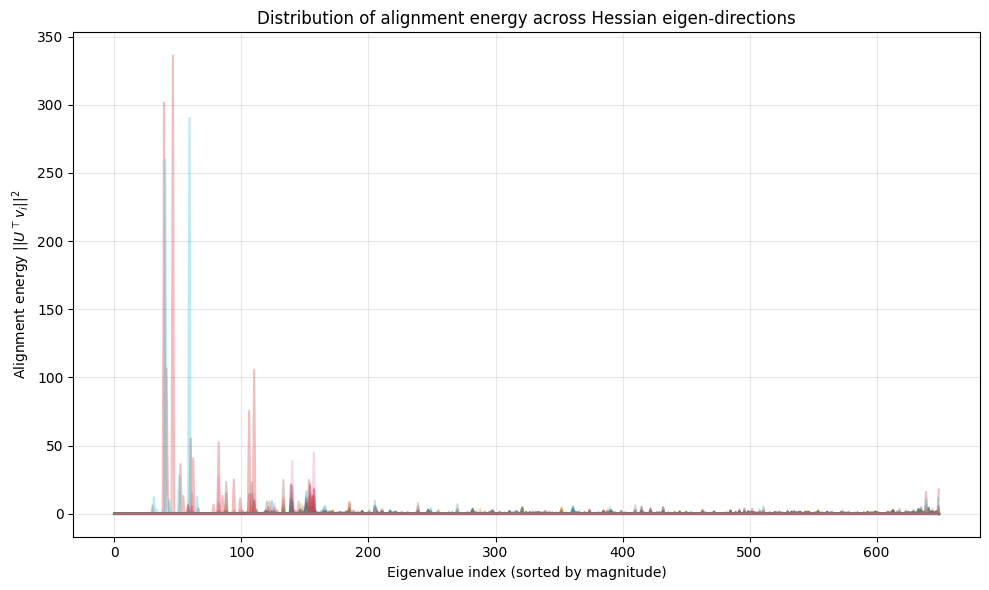

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1️⃣ Load data
U_batch_all = torch.load('checkpoints/U_batch_unlabeled_initial.pt')  # (data_num, 650, 10)
H_diag = return_hessian_eigenvalues(model, train_set_Labeled)  # (650,)

# 2️⃣ Sort Hessian (and align eigenvectors accordingly)
sorted_idx = torch.argsort(H_diag)
H_sorted = H_diag[sorted_idx]

# 3️⃣ Sort U_batch_all to match eigenvalue order
U_sorted = U_batch_all[:, sorted_idx, :]  # (data_num, 650, 10)

# 4️⃣ Compute alignment energy for each sample
alignment_energy = (U_sorted ** 2).sum(dim=2)  # (data_num, 650)
print(f"✅ Computed alignment energy shape: {alignment_energy.shape}")

# 5️⃣ Plot all sample curves
plt.figure(figsize=(10,6))
for i in range(U_batch_all.shape[0]):
    plt.plot(range(len(H_sorted)), alignment_energy[i].detach().numpy(), alpha=0.3)

plt.xlabel("Eigenvalue index (sorted by magnitude)")
plt.ylabel(r"Alignment energy $||U^\top v_i||^2$")
plt.title("Distribution of alignment energy across Hessian eigen-directions")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

✅ Computed alignment energy shape: torch.Size([1317, 650])


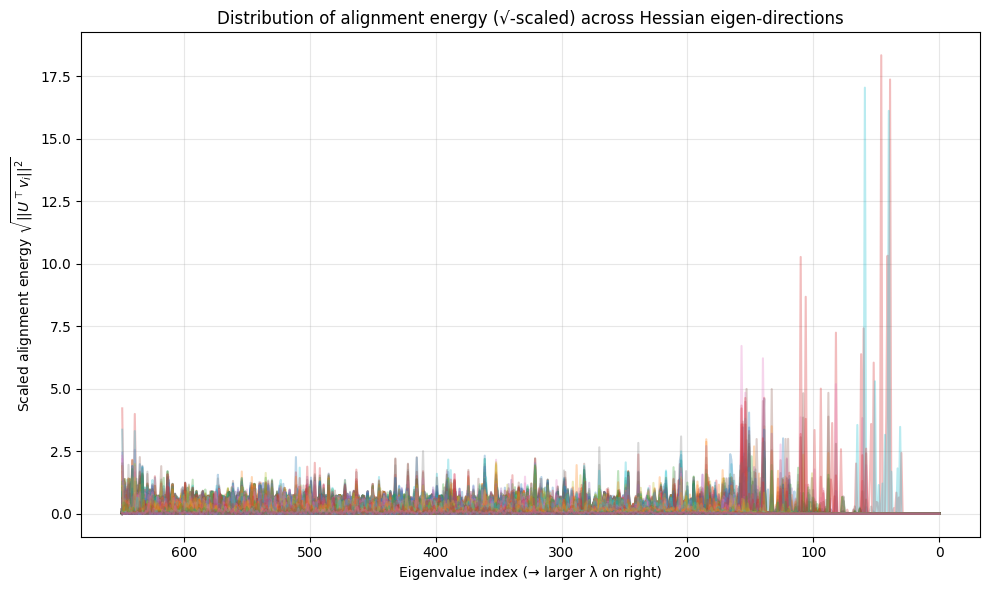

In [22]:
import torch
import matplotlib.pyplot as plt

# 1️⃣ Load data
U_batch_all = torch.load('checkpoints/U_batch_unlabeled_initial.pt')  # (data_num, 650, 10)
H_diag = return_hessian_eigenvalues(model, train_set_Labeled)  # (650,)

# 2️⃣ Sort Hessian ascending (small→large)
sorted_idx = torch.argsort(H_diag)
H_sorted = H_diag[sorted_idx]

# 3️⃣ Align U with sorted eigenvalues
U_sorted = U_batch_all[:, sorted_idx, :]  # (data_num, 650, 10)

# 4️⃣ Compute alignment energy per eigenvector
alignment_energy = (U_sorted ** 2).sum(dim=2)  # (data_num, 650)
alignment_energy_sqrt = alignment_energy.sqrt()  # 🔹 sqrt scaling

print(f"✅ Computed alignment energy shape: {alignment_energy.shape}")

# 5️⃣ Plot all sample curves (sqrt-scaled energy, reversed x-axis)
plt.figure(figsize=(10,6))
for i in range(U_batch_all.shape[0]):
    plt.plot(range(len(H_sorted)), alignment_energy_sqrt[i].detach().numpy(), alpha=0.3)

plt.gca().invert_xaxis()  # 🔹 right side = large eigenvalue

plt.xlabel("Eigenvalue index (→ larger λ on right)")
plt.ylabel(r"Scaled alignment energy $\sqrt{||U^\top v_i||^2}$")
plt.title("Distribution of alignment energy (√-scaled) across Hessian eigen-directions")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


✅ Computed alignment energy shape: torch.Size([1317, 650])


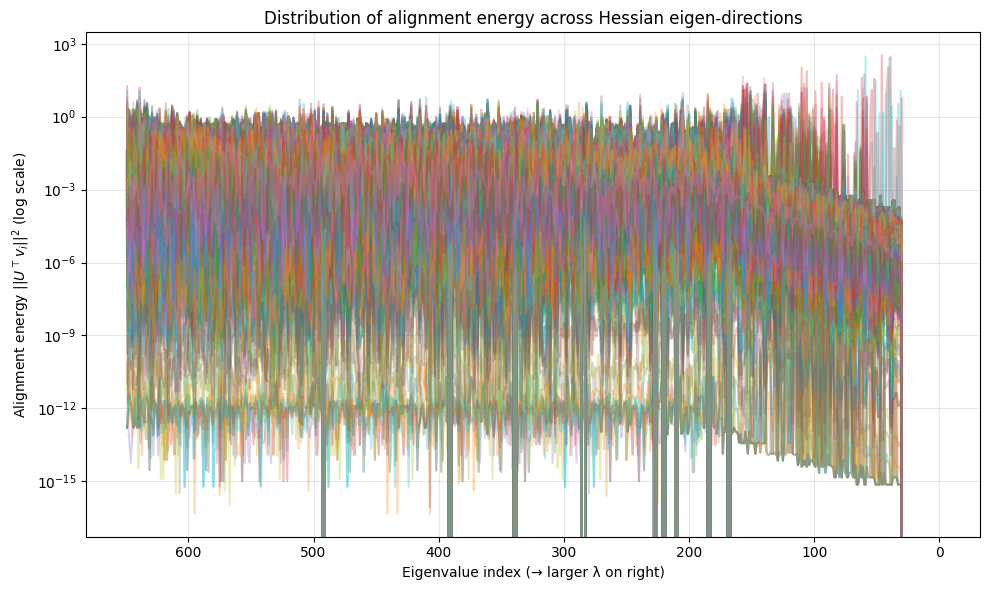

In [20]:
import torch
import matplotlib.pyplot as plt

# 1️⃣ Load data
U_batch_all = torch.load('checkpoints/U_batch_unlabeled_initial.pt')  # (data_num, 650, 10)
H_diag = return_hessian_eigenvalues(model, train_set_Labeled)  # (650,)

# 2️⃣ Sort Hessian ascending (small→large)
sorted_idx = torch.argsort(H_diag)
H_sorted = H_diag[sorted_idx]

# 3️⃣ Align U with sorted eigenvalues
U_sorted = U_batch_all[:, sorted_idx, :]  # (data_num, 650, 10)

# 4️⃣ Compute alignment energy per eigenvector
alignment_energy = (U_sorted ** 2).sum(dim=2)  # (data_num, 650)
print(f"✅ Computed alignment energy shape: {alignment_energy.shape}")

# 5️⃣ Plot all sample curves (log-scale, reversed x-axis)
plt.figure(figsize=(10,6))
for i in range(U_batch_all.shape[0]):
    plt.plot(range(len(H_sorted)), alignment_energy[i].detach().numpy(), alpha=0.3)

plt.yscale("log")  # 🔹 log scale for energy
plt.gca().invert_xaxis()  # 🔹 right side = large eigenvalue

plt.xlabel("Eigenvalue index (→ larger λ on right)")
plt.ylabel(r"Alignment energy $||U^\top v_i||^2$ (log scale)")
plt.title("Distribution of alignment energy across Hessian eigen-directions")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
U_batch_all.shape

torch.Size([1317, 650, 10])


📈 U matrix Statistics:
   Mean: 0.000000
   Std:  0.050730
   Min:  -8.850388
   Max:  15.888417

📊 Frobenius Norms:
   Mean: 3.2891
   Std:  2.4319
   Min:  0.0001
   Max:  31.6833


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

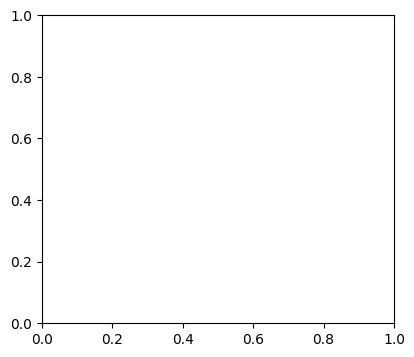

In [ ]:
# U matrix 통계 분석
print(f"\n📈 U matrix Statistics:")
print(f"   Mean: {U_batch_all.mean().item():.6f}")
print(f"   Std:  {U_batch_all.std().item():.6f}")
print(f"   Min:  {U_batch_all.min().item():.6f}")
print(f"   Max:  {U_batch_all.max().item():.6f}")

# 각 샘플의 Frobenius norm 계산
frobenius_norms = torch.norm(U_batch_all, p='fro', dim=(1,2))
print(f"\n📊 Frobenius Norms:")
print(f"   Mean: {frobenius_norms.mean().item():.4f}")
print(f"   Std:  {frobenius_norms.std().item():.4f}")
print(f"   Min:  {frobenius_norms.min().item():.4f}")
print(f"   Max:  {frobenius_norms.max().item():.4f}")


# 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(frobenius_norms, bins=50, alpha=0.7, color='blue')
plt.xlabel('Frobenius Norm')
plt.ylabel('Frequency')
plt.title('Distribution of U Matrix Norms')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(frobenius_norms.cpu().numpy(), alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Frobenius Norm')
plt.title('U Matrix Norms per Sample')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('U_matrix_analysis.pdf', dpi=300, bbox_inches='tight')
print(f"✅ Saved analysis plot to U_matrix_analysis.pdf")
plt.show()

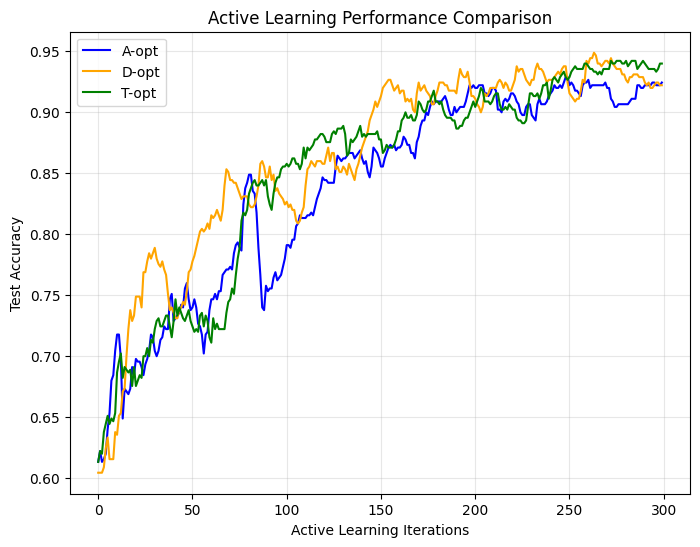

In [64]:
Hessian_data_Aopt = np.load('checkpoints/Hessian_data_Aopt.pkl',allow_pickle=True)
Hessian_data_Dopt = np.load('checkpoints/Hessian_data_Dopt.pkl',allow_pickle=True)
Hessian_data_Topt = np.load('checkpoints/Hessian_data_Topt.pkl',allow_pickle=True)
accuracy_data_Aopt = np.load('checkpoints/accuracy_data_Aopt.pkl',allow_pickle=True)
accuracy_data_Dopt = np.load('checkpoints/accuracy_data_Dopt.pkl',allow_pickle=True)
accuracy_data_Topt = np.load('checkpoints/accuracy_data_Topt.pkl',allow_pickle=True)

plt.figure(figsize=(8,6))
plt.plot(range(len(accuracy_data_Aopt)), accuracy_data_Aopt, label='A-opt', color='blue')
plt.plot(range(len(accuracy_data_Dopt)), accuracy_data_Dopt, label='D-opt', color='orange')
plt.plot(range(len(accuracy_data_Topt)), accuracy_data_Topt, label='T-opt', color='green')
plt.xlabel("Active Learning Iterations")
plt.ylabel("Test Accuracy")
plt.title("Active Learning Performance Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('AL_performance_comparison.pdf', bbox_inches='tight', dpi=300)

✅ Saved Hessian eigenvalue evolution plot → hessian_eigenvalue_evolution_Topt.pdf


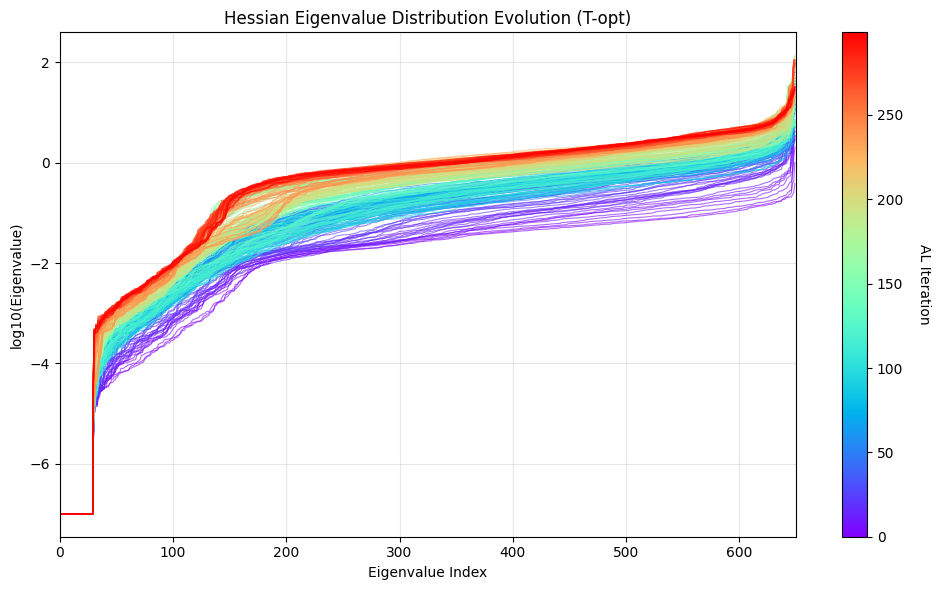

In [65]:
import matplotlib.cm as cm

def plot_hessian_eigenvalue_evolution(Hessian_data_list, title_suffix='', save_path=None):
    """
    Hessian_data_list: list of np.arrays of eigenvalues at each AL iteration
    title_suffix: additional string to add to the plot title
    save_path: if provided, saves the figure to this path
    """
    n_iterations = len(Hessian_data_list)
    colors = cm.rainbow(np.linspace(0, 1, n_iterations))  # viridis → rainbow
    base_eigvals = Hessian_data_list[0]
    plt.figure(figsize=(10, 6))

    for i in range(n_iterations):
        sorted_eigvals = np.sort(Hessian_data_list[i])
        plt.plot(np.log10(sorted_eigvals + 1e-7) , color=colors[i], alpha=0.6, linewidth=0.8)

    plt.xlabel('Eigenvalue Index')
    plt.ylabel('log10(Eigenvalue)')
    plt.xlim(0, len(Hessian_data_list[0]))
    plt.title(f'Hessian Eigenvalue Distribution Evolution {title_suffix}')
    plt.grid(True, alpha=0.3)

    # Colorbar 추가
    sm = cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0, vmax=n_iterations-1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('AL Iteration', rotation=270, labelpad=20)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✅ Saved Hessian eigenvalue evolution plot → {save_path}")
    plt.show()
'''
plot_hessian_eigenvalue_evolution(Hessian_data_Aopt, title_suffix='(A-opt)', save_path='hessian_eigenvalue_evolution_Aopt.pdf')
plot_hessian_eigenvalue_evolution(Hessian_data_Dopt, title_suffix='(D-opt)', save_path='hessian_eigenvalue_evolution_Dopt.pdf')
'''
plot_hessian_eigenvalue_evolution(Hessian_data_Topt, title_suffix='(T-opt)', save_path='hessian_eigenvalue_evolution_Topt.pdf')

✅ Saved Hessian eigenvalue evolution plot → hessian_eigenvalue_evolution_Aopt.pdf


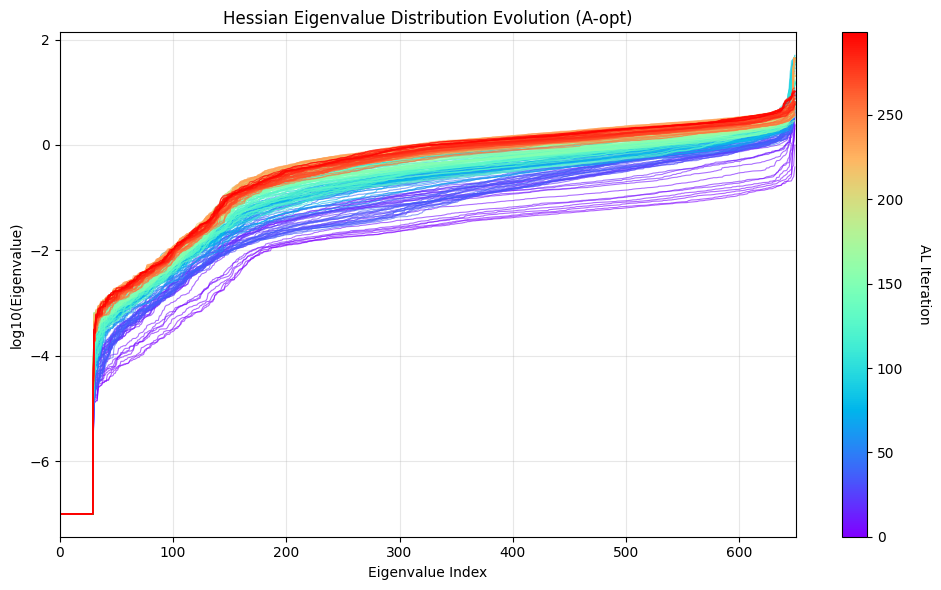

✅ Saved Hessian eigenvalue evolution plot → hessian_eigenvalue_evolution_Dopt.pdf


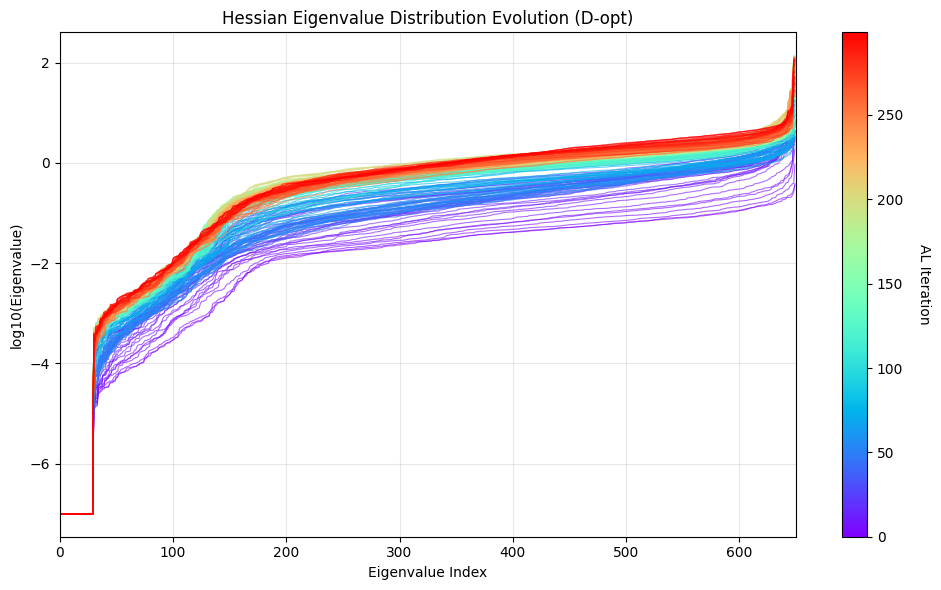

In [ ]:
import matplotlib.cm as cm

def plot_hessian_eigenvalue_evolution(Hessian_data_list, title_suffix='', save_path=None):
    """
    Hessian_data_list: list of np.arrays of eigenvalues at each AL iteration
    title_suffix: additional string to add to the plot title
    save_path: if provided, saves the figure to this path
    """
    n_iterations = len(Hessian_data_list)
    colors = cm.rainbow(np.linspace(0, 1, n_iterations))  # viridis → rainbow

    plt.figure(figsize=(10, 6))

    for i in range(n_iterations):
        sorted_eigvals = np.sort(Hessian_data_list[i])
        plt.plot(np.log10(sorted_eigvals + 1e-7), color=colors[i], alpha=0.6, linewidth=0.8)

    plt.xlabel('Eigenvalue Index')
    plt.ylabel('log10(Eigenvalue)')
    plt.xlim(0, len(Hessian_data_list[0]))
    plt.title(f'Hessian Eigenvalue Distribution Evolution {title_suffix}')
    plt.grid(True, alpha=0.3)

    # Colorbar 추가
    sm = cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0, vmax=n_iterations-1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('AL Iteration', rotation=270, labelpad=20)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✅ Saved Hessian eigenvalue evolution plot → {save_path}")
    plt.show()
    
plot_hessian_eigenvalue_evolution(Hessian_data_Aopt, title_suffix='(A-opt)', save_path='hessian_eigenvalue_evolution_Aopt.pdf')
plot_hessian_eigenvalue_evolution(Hessian_data_Dopt, title_suffix='(D-opt)', save_path='hessian_eigenvalue_evolution_Dopt.pdf')


✅ Saved final step comparison → final_step_comparison.pdf


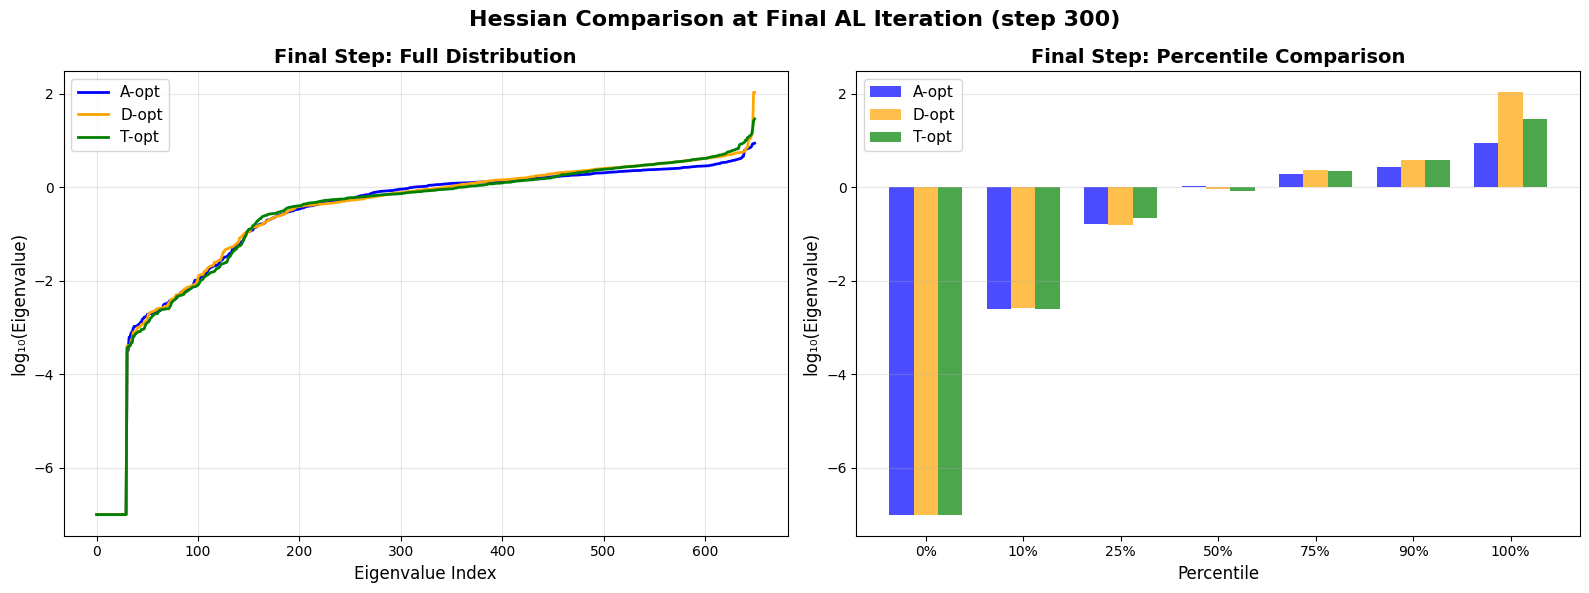

In [66]:
def plot_final_step_comparison(Hessian_data_Aopt, Hessian_data_Dopt, Hessian_data_Topt,
                                save_path='final_step_comparison.pdf'):
    """
    마지막 AL step의 A-opt vs D-opt vs T-opt eigenvalue 분포 비교
    """
    # 마지막 step 데이터
    final_aopt = np.sort(Hessian_data_Aopt[-1])
    final_dopt = np.sort(Hessian_data_Dopt[-1])
    final_topt = np.sort(Hessian_data_Topt[-1]) 
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1️⃣ 왼쪽: 전체 eigenvalue 분포
    ax1 = axes[0]
    ax1.plot(np.log10(final_aopt + 1e-7), label='A-opt', color='blue', linewidth=2)
    ax1.plot(np.log10(final_dopt + 1e-7), label='D-opt', color='orange', linewidth=2)
    ax1.plot(np.log10(final_topt + 1e-7), label='T-opt', color='green', linewidth=2)
    ax1.set_xlabel('Eigenvalue Index', fontsize=12)
    ax1.set_ylabel('log₁₀(Eigenvalue)', fontsize=12)
    ax1.set_title('Final Step: Full Distribution', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2️⃣ 오른쪽: Percentile별 비교
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    aopt_percentiles = [np.percentile(final_aopt, p) for p in percentiles]
    dopt_percentiles = [np.percentile(final_dopt, p) for p in percentiles]
    topt_percentiles = [np.percentile(final_topt, p) for p in percentiles]
    
    ax2 = axes[1]
    x = np.arange(len(percentiles))
    width = 0.25
    
    ax2.bar(x - width, np.log10(np.array(aopt_percentiles) + 1e-7), 
            width, label='A-opt', color='blue', alpha=0.7)
    ax2.bar(x, np.log10(np.array(dopt_percentiles) + 1e-7), 
            width, label='D-opt', color='orange', alpha=0.7)
    ax2.bar(x + width, np.log10(np.array(topt_percentiles) + 1e-7), 
            width, label='T-opt', color='green', alpha=0.7)
    
    ax2.set_xlabel('Percentile', fontsize=12)
    ax2.set_ylabel('log₁₀(Eigenvalue)', fontsize=12)
    ax2.set_title('Final Step: Percentile Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{p}%' for p in percentiles])
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Hessian Comparison at Final AL Iteration (step {len(Hessian_data_Aopt)})', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved final step comparison → {save_path}")
    plt.show()


# 사용
plot_final_step_comparison(Hessian_data_Aopt, Hessian_data_Dopt, Hessian_data_Topt,
                           save_path='final_step_comparison.pdf')


C:\Users\user\AppData\Local\Temp\ipykernel_28520\854343053.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Saved comparison plot → hessian_comparison_percentile.pdf


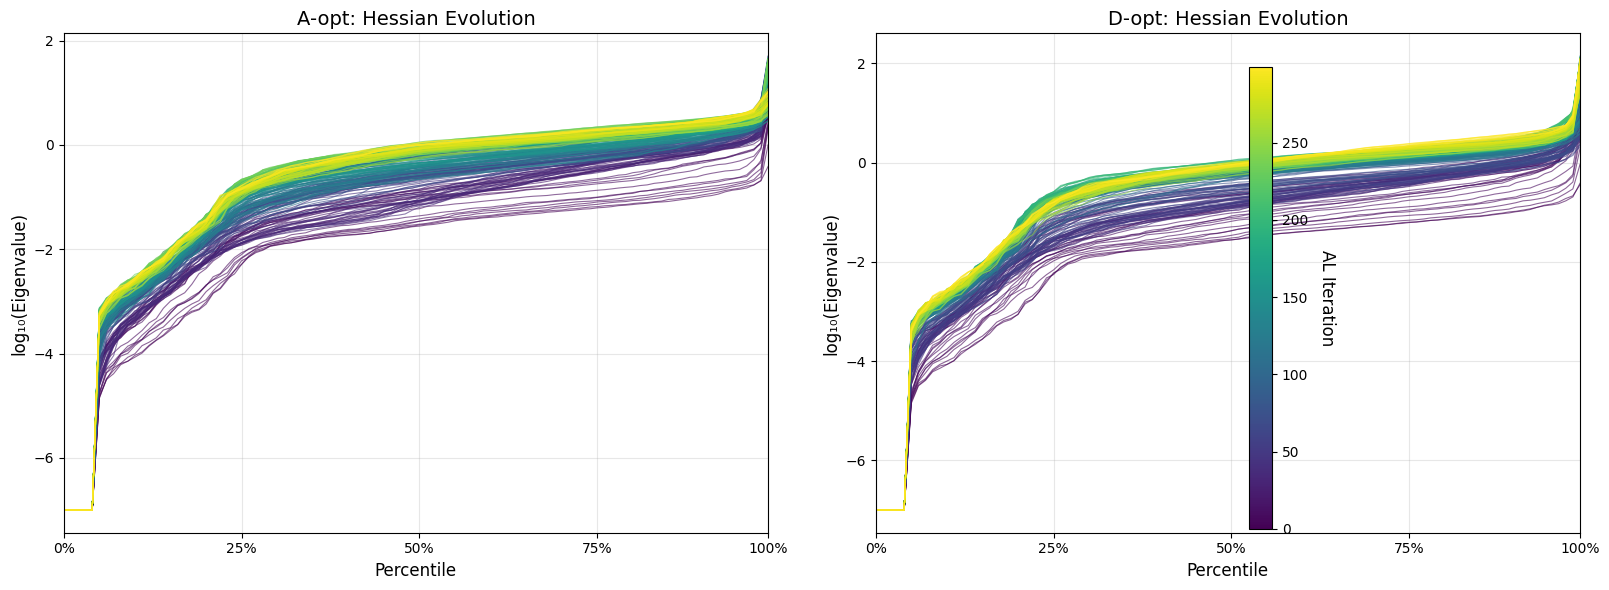

In [ ]:
import matplotlib.cm as cm

def plot_hessian_eigenvalue_evolution(Hessian_data_list, title_suffix='', save_path=None):
    """
    Hessian_data_list: list of np.arrays of eigenvalues at each AL iteration
    title_suffix: additional string to add to the plot title
    save_path: if provided, saves the figure to this path
    """
    n_iterations = len(Hessian_data_list)
    colors = cm.viridis(np.linspace(0, 1, n_iterations))

    plt.figure(figsize=(10, 6))
    for i in range(n_iterations):
        sorted_eigvals = np.sort(Hessian_data_list[i])
        plt.plot(np.log10(sorted_eigvals + 1e-7), color=colors[i], alpha=0.6, linewidth=0.8)

    plt.xlabel('Eigenvalue Index')
    plt.ylabel('log10(Eigenvalue)')
    plt.xlim(0, len(Hessian_data_list[0]))
    plt.title(f'Hessian Eigenvalue Distribution Evolution {title_suffix}')
    plt.grid(True, alpha=0.3)

    # Colorbar 추가
    sm = cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=n_iterations-1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('AL Iteration', rotation=270, labelpad=20)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✅ Saved Hessian eigenvalue evolution plot → {save_path}")
    plt.show()
    
plot_hessian_eigenvalue_evolution(Hessian_data_Aopt, title_suffix='(A-opt)', save_path='hessian_eigenvalue_evolution_Aopt.pdf')
plot_hessian_eigenvalue_evolution(Hessian_data_Dopt, title_suffix='(D-opt)', save_path='hessian_eigenvalue_evolution_Dopt.pdf')


✅ Saved percentile evolution comparison → hessian_percentile_evolution.pdf


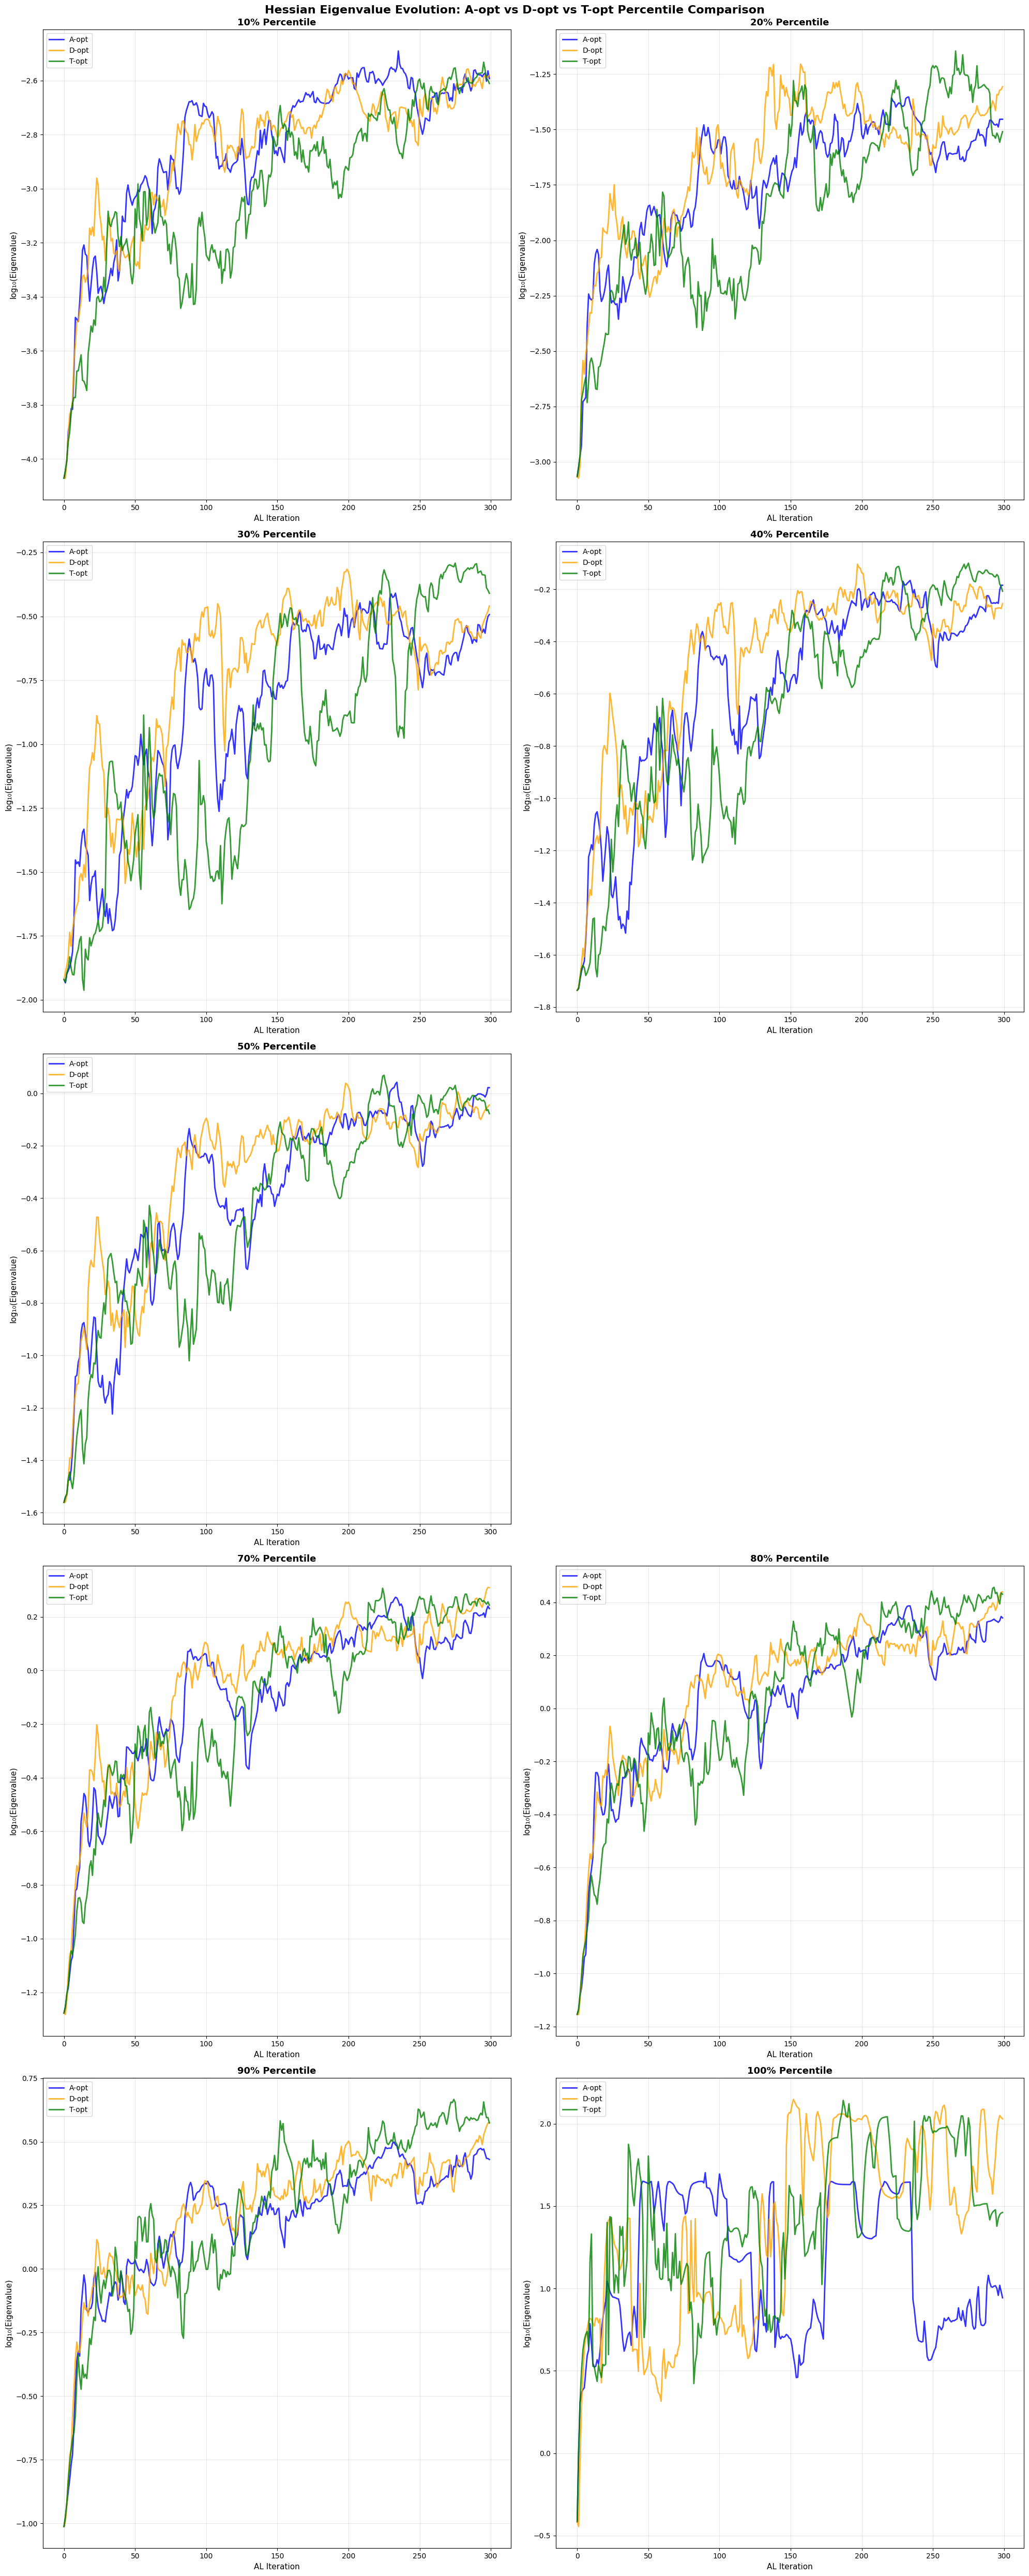

In [68]:
def plot_percentile_evolution_comparison(Hessian_data_Aopt, Hessian_data_Dopt, Hessian_data_Topt,
                                         save_path='hessian_percentile_evolution.pdf'):
    """
    A-opt와 D-opt의 각 percentile (0%, 25%, 50%, 75%, 100%) eigenvalue 변화를 
    AL iteration에 따라 비교하는 5개 서브플롯
    """
    fig, axes = plt.subplots(5, 2, figsize=(20, 50))
    axes = axes.flatten()

    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    percentile_names = ['10%', '20%','30%', '40%', '50%', '60%', '70%', '80%', '90%','100%']

    n_iters_aopt = len(Hessian_data_Aopt)
    n_iters_dopt = len(Hessian_data_Dopt)
    n_iters_topt = len(Hessian_data_Topt)
    
    for idx, (pct, pct_name) in enumerate(zip(percentiles, percentile_names)):
        ax = axes[idx]
        
        # A-opt 데이터
        aopt_values = []
        for i in range(n_iters_aopt):
            sorted_eigvals = np.sort(Hessian_data_Aopt[i])
            pct_value = np.percentile(sorted_eigvals, pct)
            aopt_values.append(pct_value)
        
        # D-opt 데이터
        dopt_values = []
        for i in range(n_iters_dopt):
            sorted_eigvals = np.sort(Hessian_data_Dopt[i])
            pct_value = np.percentile(sorted_eigvals, pct)
            dopt_values.append(pct_value)
        
        # T-opt 데이터
        topt_values = []
        for i in range(n_iters_topt):
            sorted_eigvals = np.sort(Hessian_data_Topt[i])
            pct_value = np.percentile(sorted_eigvals, pct)
            topt_values.append(pct_value)
        
        # 플롯
        ax.plot(range(n_iters_aopt), np.log10(np.array(aopt_values) + 1e-7), 
               label='A-opt', color='blue', linewidth=2, alpha=0.8)
        ax.plot(range(n_iters_dopt), np.log10(np.array(dopt_values) + 1e-7), 
               label='D-opt', color='orange', linewidth=2, alpha=0.8)
        ax.plot(range(n_iters_topt), np.log10(np.array(topt_values) + 1e-7), 
               label='T-opt', color='green', linewidth=2, alpha=0.8)
        
        ax.set_xlabel('AL Iteration', fontsize=11)
        ax.set_ylabel('log₁₀(Eigenvalue)', fontsize=11)
        ax.set_title(f'{pct_name} Percentile', fontsize=13, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # 마지막 빈 서브플롯 제거
    fig.delaxes(axes[5])
    
    plt.suptitle('Hessian Eigenvalue Evolution: A-opt vs D-opt vs T-opt Percentile Comparison', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved percentile evolution comparison → {save_path}")
    plt.show()


# 사용
plot_percentile_evolution_comparison(Hessian_data_Aopt, Hessian_data_Dopt, Hessian_data_Topt,
                                    save_path='hessian_percentile_evolution.pdf')

✅ Saved eigenvalue change ratio plot → eigenvalue_change_ratio.pdf


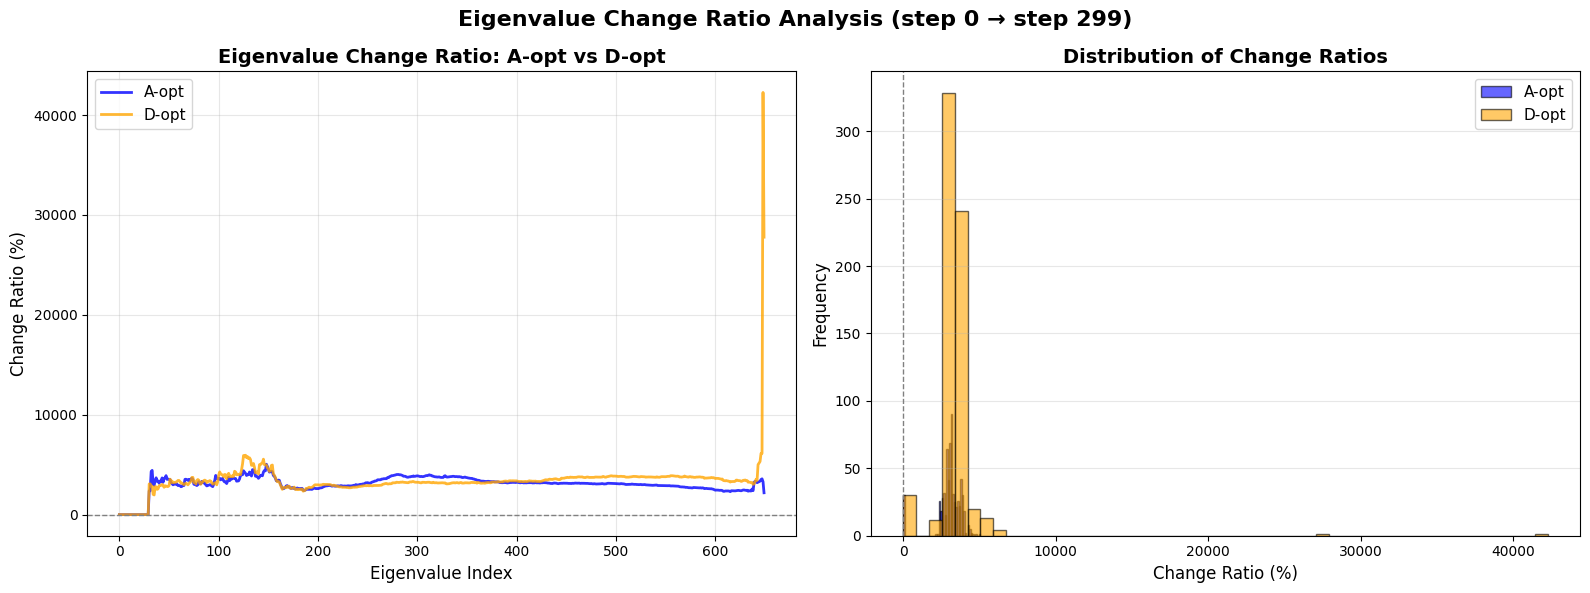

In [56]:
def plot_eigenvalue_change_ratio_comparison(Hessian_data_Aopt, Hessian_data_Dopt, 
                                           save_path='eigenvalue_change_ratio.pdf'):
    """
    초기 대비 최종 eigenvalue 변화율(%) 비교
    """
    initial_aopt = np.sort(Hessian_data_Aopt[0])
    final_aopt = np.sort(Hessian_data_Aopt[-1])
    initial_dopt = np.sort(Hessian_data_Dopt[0])
    final_dopt = np.sort(Hessian_data_Dopt[-1])
    
    # 변화율 계산 (%)
    ratio_aopt = ((final_aopt - initial_aopt) / (initial_aopt + 1e-7)) * 100
    ratio_dopt = ((final_dopt - initial_dopt) / (initial_dopt + 1e-7)) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1️⃣ 왼쪽: 변화율 분포
    ax1 = axes[0]
    ax1.plot(ratio_aopt, label='A-opt', color='blue', linewidth=2, alpha=0.8)
    ax1.plot(ratio_dopt, label='D-opt', color='orange', linewidth=2, alpha=0.8)
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax1.set_xlabel('Eigenvalue Index', fontsize=12)
    ax1.set_ylabel('Change Ratio (%)', fontsize=12)
    ax1.set_title('Eigenvalue Change Ratio: A-opt vs D-opt', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2️⃣ 오른쪽: 히스토그램
    ax2 = axes[1]
    ax2.hist(ratio_aopt, bins=50, alpha=0.6, label='A-opt', color='blue', edgecolor='black')
    ax2.hist(ratio_dopt, bins=50, alpha=0.6, label='D-opt', color='orange', edgecolor='black')
    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel('Change Ratio (%)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Change Ratios', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Eigenvalue Change Ratio Analysis (step 0 → step {len(Hessian_data_Aopt)-1})', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved eigenvalue change ratio plot → {save_path}")
    plt.show()


# 사용
plot_eigenvalue_change_ratio_comparison(Hessian_data_Aopt, Hessian_data_Dopt, 
                                       save_path='eigenvalue_change_ratio.pdf')

✅ Saved eigenvalue change comparison → eigenvalue_change_comparison.pdf


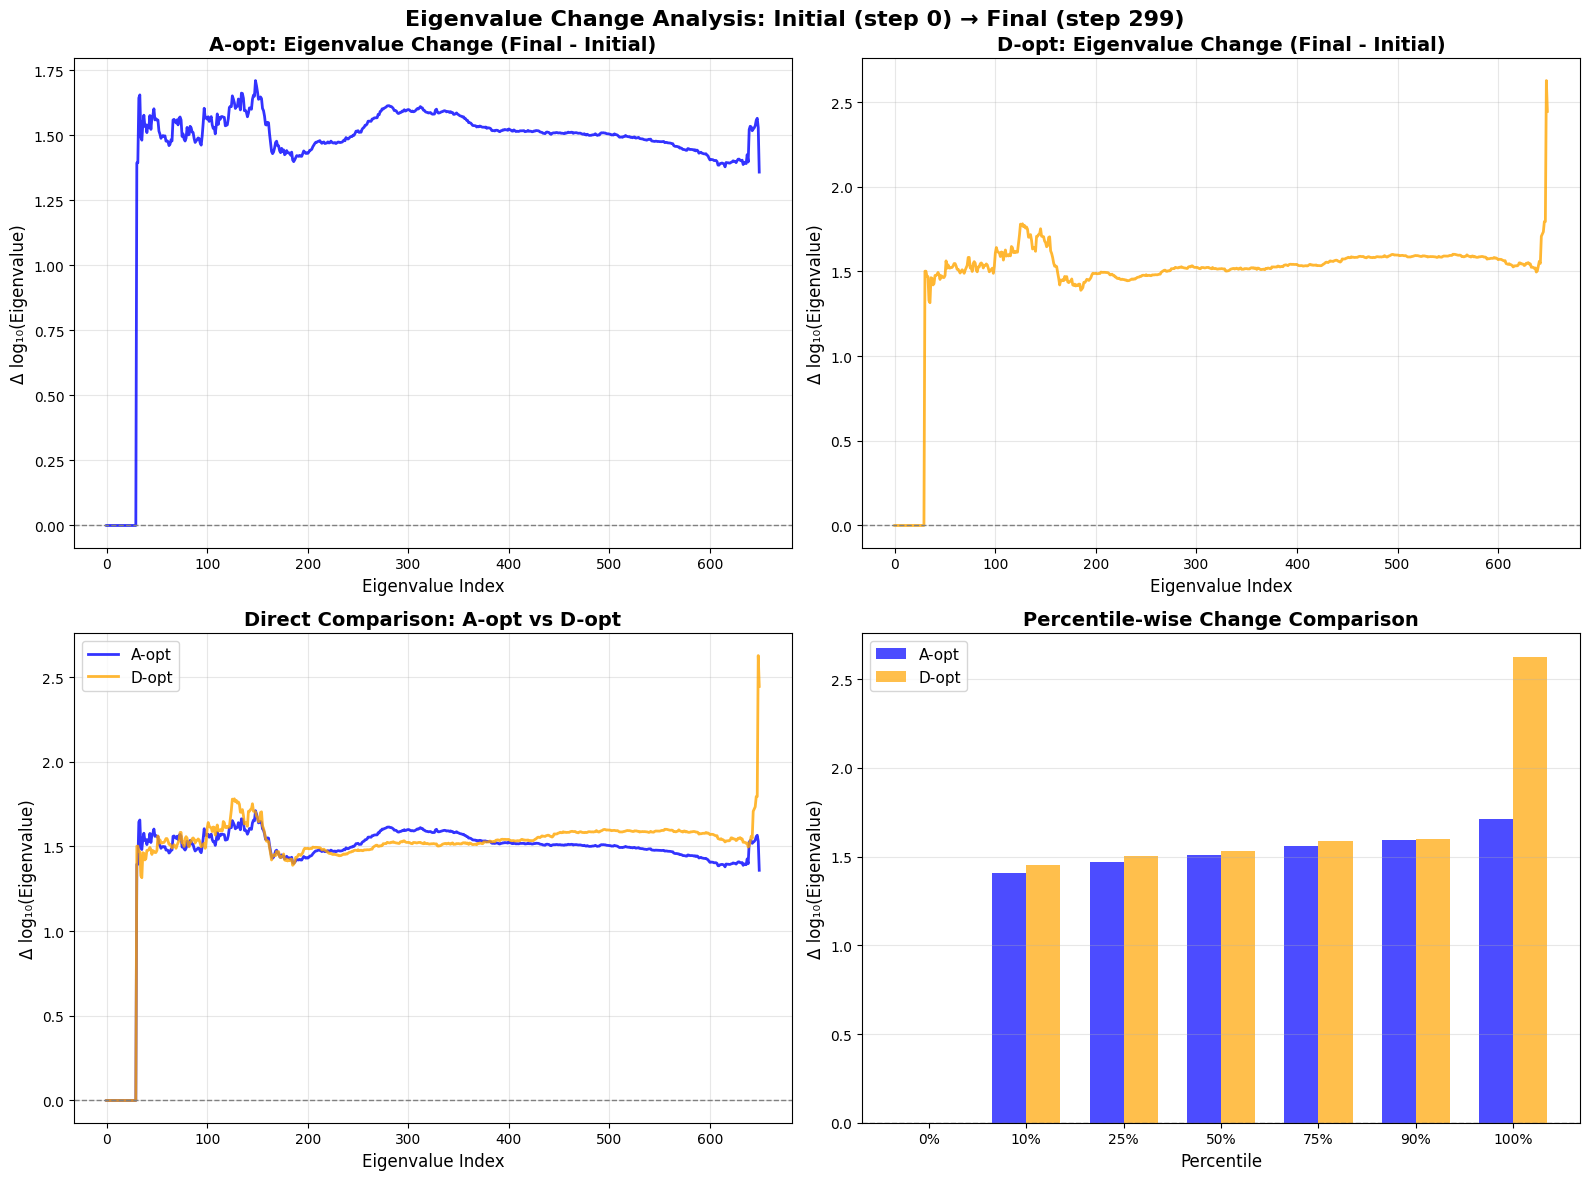

In [58]:
def plot_eigenvalue_change_comparison(Hessian_data_Aopt, Hessian_data_Dopt, 
                                      save_path='eigenvalue_change_comparison.pdf'):
    """
    초기 step → 최종 step eigenvalue 변화량 비교
    """
    # 초기와 최종 데이터
    initial_aopt = np.sort(Hessian_data_Aopt[0])
    final_aopt = np.sort(Hessian_data_Aopt[-1])
    initial_dopt = np.sort(Hessian_data_Dopt[0])
    final_dopt = np.sort(Hessian_data_Dopt[-1])
    
    # 변화량 계산 (log space에서)
    change_aopt = np.log10(final_aopt + 1e-7) - np.log10(initial_aopt + 1e-7)
    change_dopt = np.log10(final_dopt + 1e-7) - np.log10(initial_dopt + 1e-7)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1️⃣ 왼쪽 위: A-opt 변화량
    ax1 = axes[0, 0]
    ax1.plot(change_aopt, color='blue', linewidth=2, alpha=0.8)
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax1.set_xlabel('Eigenvalue Index', fontsize=12)
    ax1.set_ylabel('Δ log₁₀(Eigenvalue)', fontsize=12)
    ax1.set_title('A-opt: Eigenvalue Change (Final - Initial)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2️⃣ 오른쪽 위: D-opt 변화량
    ax2 = axes[0, 1]
    ax2.plot(change_dopt, color='orange', linewidth=2, alpha=0.8)
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel('Eigenvalue Index', fontsize=12)
    ax2.set_ylabel('Δ log₁₀(Eigenvalue)', fontsize=12)
    ax2.set_title('D-opt: Eigenvalue Change (Final - Initial)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3️⃣ 왼쪽 아래: 직접 비교
    ax3 = axes[1, 0]
    ax3.plot(change_aopt, label='A-opt', color='blue', linewidth=2, alpha=0.8)
    ax3.plot(change_dopt, label='D-opt', color='orange', linewidth=2, alpha=0.8)
    ax3.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax3.set_xlabel('Eigenvalue Index', fontsize=12)
    ax3.set_ylabel('Δ log₁₀(Eigenvalue)', fontsize=12)
    ax3.set_title('Direct Comparison: A-opt vs D-opt', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # 4️⃣ 오른쪽 아래: Percentile별 변화량 비교
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    aopt_changes = [np.percentile(change_aopt, p) for p in percentiles]
    dopt_changes = [np.percentile(change_dopt, p) for p in percentiles]
    
    ax4 = axes[1, 1]
    x = np.arange(len(percentiles))
    width = 0.35
    
    ax4.bar(x - width/2, aopt_changes, width, label='A-opt', color='blue', alpha=0.7)
    ax4.bar(x + width/2, dopt_changes, width, label='D-opt', color='orange', alpha=0.7)
    ax4.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    
    ax4.set_xlabel('Percentile', fontsize=12)
    ax4.set_ylabel('Δ log₁₀(Eigenvalue)', fontsize=12)
    ax4.set_title('Percentile-wise Change Comparison', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels([f'{p}%' for p in percentiles])
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Eigenvalue Change Analysis: Initial (step 0) → Final (step {len(Hessian_data_Aopt)-1})', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved eigenvalue change comparison → {save_path}")
    plt.show()


# 사용
plot_eigenvalue_change_comparison(Hessian_data_Aopt, Hessian_data_Dopt, 
                                 save_path='eigenvalue_change_comparison.pdf')